In [1]:
import pandas as pd
import numpy as np

from create_test_and_training_set import create_test_set_data
from collections import defaultdict


def clean_players(players: pd.DataFrame):
    players = players.drop(['firstseason','lastseason'], axis='columns') # all players with first and last season 0
    players = players[players["bioID"].isin(players_teams["playerID"])]
    return players

def clean_players_teams(players_teams: pd.DataFrame):
    return players_teams.drop('lgID', axis='columns') # same lgID

def clean_awards_players(awards_players: pd.DataFrame):
    return awards_players.drop("lgID", axis="columns")

def clean_coaches(coaches: pd.DataFrame):
    return coaches.drop("lgID", axis="columns")

def clean_teams_post(teams_post : pd.DataFrame):
    return teams_post.drop("lgID", axis="columns")

def clean_series_post(series_post : pd.DataFrame):
    return series_post.drop(["lgIDLoser", "lgIDWinner"], axis="columns")

def clean_teams(teams : pd.DataFrame):
    return teams.drop(["lgID", "franchID", "divID", "arena", "attend", "min", "name"], axis="columns")

def parse_player_team_data(df):
    """
    Parses the player-team-season dataset into structured Python dictionaries
    for further analysis and championship prediction.
    """

    df.columns = [c.strip() for c in df.columns]
    df.fillna(0, inplace=True)

    players = defaultdict(list)
    teams_by_year = defaultdict(lambda: defaultdict(list))

    for _, row in df.iterrows():
        playerID = row["playerID"]
        teamID = row["tmID"]
        year = int(row["year"])

        # Regular season stats
        season_stats = {
            "GP": row["GP"],
            "GS": row["GS"],
            "minutes": row["minutes"],
            "points": row["points"],
            "oRebounds": row["oRebounds"],
            "dRebounds": row["dRebounds"],
            "rebounds": row["rebounds"],
            "assists": row["assists"],
            "steals": row["steals"],
            "blocks": row["blocks"],
            "turnovers": row["turnovers"],
            "PF": row["PF"],
            "fgAttempted": row["fgAttempted"],
            "fgMade": row["fgMade"],
            "ftAttempted": row["ftAttempted"],
            "ftMade": row["ftMade"],
            "threeAttempted": row["threeAttempted"],
            "threeMade": row["threeMade"],
            "dq": row["dq"],
        }

        # Postseason stats
        postseason_stats = {
            "PostGP": row["PostGP"],
            "PostGS": row["PostGS"],
            "PostMinutes": row["PostMinutes"],
            "PostPoints": row["PostPoints"],
            "PostoRebounds": row["PostoRebounds"],
            "PostdRebounds": row["PostdRebounds"],
            "PostRebounds": row["PostRebounds"],
            "PostAssists": row["PostAssists"],
            "PostSteals": row["PostSteals"],
            "PostBlocks": row["PostBlocks"],
            "PostTurnovers": row["PostTurnovers"],
            "PostPF": row["PostPF"],
            "PostfgAttempted": row["PostfgAttempted"],
            "PostfgMade": row["PostfgMade"],
            "PostftAttempted": row["PostftAttempted"],
            "PostftMade": row["PostftMade"],
            "PostthreeAttempted": row["PostthreeAttempted"],
            "PostthreeMade": row["PostthreeMade"],
            "PostDQ": row["PostDQ"],
        }

        # Combined player record
        record = {
            "year": year,
            "teamID": teamID,
            "stint": row["stint"],
            **season_stats,
            **postseason_stats
        }

        # Store in both structures
        players[playerID].append(record)
        teams_by_year[year][teamID].append(record)

    print(f"Parsed {len(players)} players across {len(teams_by_year)} seasons.")
    return {"players": players, "teams_by_year": teams_by_year}

awards_players = clean_awards_players(pd.read_csv("basketballPlayoffs/awards_players.csv"))
coaches = clean_coaches(pd.read_csv("basketballPlayoffs/coaches.csv"))
players_teams = clean_players_teams(pd.read_csv("basketballPlayoffs/players_teams.csv"))
players = clean_players(pd.read_csv("basketballPlayoffs/players.csv"))
series_post = clean_series_post(pd.read_csv("basketballPlayoffs/series_post.csv"))
teams_post = clean_teams_post(pd.read_csv("basketballPlayoffs/teams_post.csv"))
teams = clean_teams(pd.read_csv("basketballPlayoffs/teams.csv"))

# For year 11

coaches_11 = pd.read_csv("Season_11/coaches.csv")
players_teams_11 = pd.read_csv("Season_11/players_teams.csv")
teams_11 = pd.read_csv("Season_11/teams.csv")

Merge year 11 with our data

In [2]:
coaches = pd.concat([coaches, coaches_11], ignore_index=True)
players_teams = pd.concat([players_teams, players_teams_11], ignore_index=True)
teams = pd.concat([teams, teams_11], ignore_index=True)

In [3]:
teams["FG_Percentage"] = teams["o_fgm"] / teams["o_fga"]*100 # Field goal percentage
teams["FT_Percentage"] = teams["o_ftm"] / teams["o_fta"]*100 # Free-Throw percentage
teams["3P_Percentage"] = teams["o_3pm"] / teams["o_3pa"]*100 # 3 Point percentage
teams["O_OREBPG"] = teams["o_oreb"] / teams["GP"] # Ofensive rebounds per game
teams["O_DREBPG"] = teams["o_dreb"] / teams["GP"] # Defensive rebounds per game
teams["TOPG"] = teams["o_to"] / teams["GP"] # Turnovers per game
teams["PPG"] = teams["o_pts"] / teams["GP"] # Points per game
teams["STLPG"] = teams["o_stl"] / teams["GP"] # Steals per game
teams["BLKPG"] = teams["o_blk"] / teams["GP"] # Blocks per game
teams["PFPG"] = teams["o_pf"] / teams["GP"] # Personal fouls per game
teams["D_PPG"] = teams["d_pts"] / teams["GP"]
teams["APG"] = teams["o_asts"] / teams["GP"] # Assists per game
teams["Win%"] = teams["won"] / teams["GP"] *100

teams[["tmID", "FG_Percentage", "FT_Percentage", "3P_Percentage", "Win%"]].head()

,tmID,FG_Percentage,FT_Percentage,3P_Percentage,Win%
0,ATL,39.636847,74.758621,33.779264,11.764706
1,ATL,44.851730,75.364238,30.481283,52.941176
2,CHA,42.669469,74.696707,33.937824,25.000000
3,CHA,41.910112,77.651515,35.747664,56.250000
4,CHA,43.016760,73.906486,40.037951,56.250000


Building awards weights

In [4]:
dict_award_weight = {
    "Most Valuable Player" : 10,
    "Coach of the Year" : 10,
    "WNBA All-Decade Team" : 6,
    "WNBA Finals Most Valuable Player" : 5,
    "WNBA All Decade Team Honorable Mention" : 4,
    "Defensive Player of the Year" : 4,
    "Most Improved Player" : 3,
    "Sixth Woman of the Year" : 2,
    "All-Star Game Most Valuable Player" : 2,
    "Rookie of the Year" : 1,
    "Kim Perrot Sportsmanship Award" : 0,
    "Kim Perrot Sportsmanship" : 0,
}

def compute_award_score(team_id, year, awards_players, players_teams,coaches, dict_award_weight):
  team_players = players_teams[
        (players_teams["tmID"] == team_id) &
        (players_teams["year"] == year)
    ]["playerID"].unique()

  player_awards = awards_players[
      (awards_players["playerID"].isin(team_players)) &
      (awards_players["year"] < year)
  ]

  #if team_id == "LAS":
  #  print(player_awards)

  player_award_score = player_awards["award"].map(dict_award_weight).sum()
  #if team_id == "LAS":
  #  print(player_award_score)

  coach_ = coaches[
      (coaches["tmID"] == team_id) &
      (coaches["year"] == year)
  ]

  #if team_id == "LAS":
   # print(coach_)

  if not coach_.empty:
        coach_id = coach_["coachID"].iloc[0]
        coach_awards = awards_players[
            (awards_players["playerID"] == coach_id) &
            (awards_players["award"] == "Coach of the Year") &
            (awards_players["year"] < year)
        ]
        coach_award_score = coach_awards["award"].map(dict_award_weight).sum()

  total_award_score = player_award_score + coach_award_score

  return total_award_score

Teams that will change coaches.

Add new var to see if coach changed

In [5]:
coaches_df = coaches.copy()

original_coaches = coaches_df.sort_values(['tmID', 'year', 'stint']).groupby(['tmID', 'year']).first().reset_index()
original_coaches.rename(columns={'coachID': 'Original_CoachID'}, inplace=True)

survivor_coaches = coaches_df.sort_values(['tmID', 'year', 'stint']).groupby(['tmID', 'year']).last().reset_index()
survivor_coaches.rename(columns={'coachID': 'Survivor_CoachID'}, inplace=True)

merged_df = pd.merge(
    original_coaches[['tmID', 'year', 'Original_CoachID']],
    survivor_coaches[['tmID', 'year', 'Survivor_CoachID']],
    on=['tmID', 'year']
)

merged_df['MidSeason_Fire'] = np.where(
    merged_df['Original_CoachID'] != merged_df['Survivor_CoachID'], 1, 0
)

merged_df['CoachChange'] = merged_df['MidSeason_Fire']


target_coaches = merged_df[['tmID', 'year', 'Original_CoachID', 'CoachChange']]
target_coaches.rename(columns={'Original_CoachID': 'coachID'}, inplace=True)
print(target_coaches)

    tmID  year     coachID  CoachChange
0    ATL     9  meadoma99w            0
1    ATL    10  meadoma99w            0
2    ATL    11  meadoma99w            0
3    CHA     1  dunntr01wc            0
4    CHA     2  donovan99w            0
..   ...   ...         ...          ...
149  WAS     7  adubari99w            0
150  WAS     8  adubari99w            1
151  WAS     9  rollitr01w            1
152  WAS    10  plankju99w            0
153  WAS    11  laceytr99w            0

[154 rows x 4 columns]


C:\Users\kensh\AppData\Local\Temp\ipykernel_2384\1183789994.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_coaches.rename(columns={'Original_CoachID': 'coachID'}, inplace=True)


Data analysis to see which variables mostly affect the prediction.  

Check if previous year win rate affects coach change


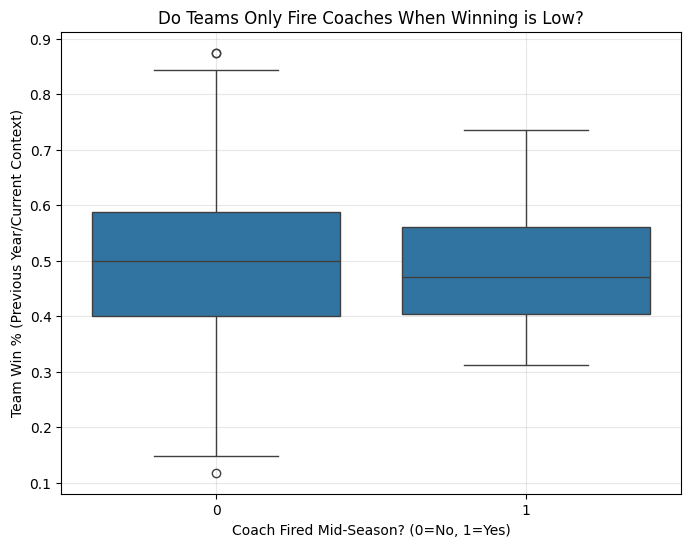

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
TARGET_YEAR = 11 #Define year to use as test
exploratory_analysis = target_coaches.copy()

teams_history = teams[['year', 'tmID', 'won', 'lost', 'playoff']].copy()
teams_history['total_games'] = teams_history['won'] + teams_history['lost']
teams_history['Win_Pct'] = teams_history['won'] / teams_history['total_games']

prev_performance = teams_history[['year', 'tmID', 'Win_Pct', 'playoff']].copy()
prev_performance['year'] = prev_performance['year'] + 1
prev_performance = prev_performance.rename(columns={'Win_Pct': 'Prev_Team_Win_Pct', 'playoff' : 'Prev_team_playoff'})

exploratory_analysis = pd.merge(
    exploratory_analysis,
    prev_performance,
    on=['year', 'tmID'],
    how='left'
)
exploratory_analysis['Prev_Team_Win_Pct'] = exploratory_analysis['Prev_Team_Win_Pct'].fillna(0.4)

plt.figure(figsize=(8, 6))
sns.boxplot(x='CoachChange', y='Prev_Team_Win_Pct', data=exploratory_analysis)
plt.title("Do Teams Only Fire Coaches When Winning is Low?")
plt.xlabel("Coach Fired Mid-Season? (0=No, 1=Yes)")
plt.ylabel("Team Win % (Previous Year/Current Context)")
plt.grid(True, alpha=0.3)
plt.show()

Looks like Win% alone does not help.  

Will try to check if low win rate algongside team talent variable counts for something.

To calculate the talent variable, we need the teams' players stats. To calculate this we pick the variables we think impact more the quality of the player, like points, assists, blocks and etc.. . We use those metrics and create new ones like Points per game. We use those stats and apply the Player score formula.  

In [7]:
def getPlayersStats(players_group):
  career_players = players_group.groupby("playerID").agg({
    "GP": "sum",
    "points": "sum",
    "assists": "sum",
    "oRebounds": "sum",
    "dRebounds": "sum",
    "rebounds": "sum",
    "steals": "sum",
    "blocks": "sum",
    "turnovers": "sum",
    "PF": "sum",
    "fgAttempted": "sum",
    "fgMade": "sum",
    "ftAttempted": "sum",
    "ftMade": "sum",
    "threeAttempted": "sum",
    "threeMade": "sum"
    }).reset_index()

  career_players["PPG"] = career_players["points"] / career_players["GP"]
  career_players["APG"] = career_players["assists"] / career_players["GP"]
  career_players["RPG"] = career_players["rebounds"] / career_players["GP"]
  career_players["SPG"] = career_players["steals"] / career_players["GP"]
  career_players["BPG"] = career_players["blocks"] / career_players["GP"]
  career_players["TOPG"] = career_players["turnovers"] / career_players["GP"]
  career_players["PFPG"] = career_players["PF"] / career_players["GP"]
  career_players["FG_Percentage"] = career_players["fgMade"] / career_players["fgAttempted"] * 100
  career_players["FT_Percentage"] = career_players["ftMade"] / career_players["ftAttempted"] * 100
  career_players["3P_Percentage"] = career_players["threeMade"] / career_players["threeAttempted"] * 100

  career_players = career_players.round(2)

  return career_players

def players_stats_until_year(year, players_teams):

  history_end_year = year - 1

  if history_end_year < 1:
    teams_in_year = players_teams[players_teams['year'] == year]['tmID'].unique()
    return pd.DataFrame({
        'year': year,
        'tmID': teams_in_year,
        'Player_Score': 0.0
    })

  players_in_year = players_teams[players_teams["year"].between(1,history_end_year)]
  players_stats = getPlayersStats(players_in_year)

  players_stats["Player_Score"] = (
  players_stats["points"] + 0.4 * players_stats["fgMade"] + 0.7 * players_stats["oRebounds"] +
  0.3 * players_stats["dRebounds"] + players_stats["steals"] + 0.7 * players_stats["assists"] +
  0.7 * players_stats["blocks"] - 0.7 * players_stats["fgAttempted"] - 0.4 * (players_stats["ftAttempted"] - players_stats["ftMade"]) - 0.4 * players_stats["PF"] - players_stats["turnovers"]
  )

  rosters_year = players_teams[players_teams["year"] == year][['playerID', 'tmID']]

  players_scores_year = pd.merge(
      rosters_year,
      players_stats,
      on='playerID',
      how='inner'
  )

  team_names_year = teams[teams["year"] == year][['tmID']]

  final_rosters_with_scores = pd.merge(
      players_scores_year,
      team_names_year,
      on='tmID'
  )

  final_rosters_with_scores['year'] = year

  #print(final_rosters_with_scores[final_rosters_with_scores['tmID'] == 'WAS'])

  return final_rosters_with_scores

def last_year_players_stats(year, players_teams):
  last_year = year - 1

  if last_year < 1:
    teams_in_year = players_teams[players_teams['year'] == year]['tmID'].unique()
    return pd.DataFrame({
        'year': year,
        'tmID': teams_in_year,
        'Player_Score': 0.0
    })

  players_in_year = players_teams[players_teams["year"] == last_year]
  players_stats = getPlayersStats(players_in_year)

  players_stats["Player_Score"] = (
  players_stats["points"] + 0.4 * players_stats["fgMade"] + 0.7 * players_stats["oRebounds"] +
  0.3 * players_stats["dRebounds"] + players_stats["steals"] + 0.7 * players_stats["assists"] +
  0.7 * players_stats["blocks"] - 0.7 * players_stats["fgAttempted"] - 0.4 * (players_stats["ftAttempted"] - players_stats["ftMade"]) - 0.4 * players_stats["PF"] - players_stats["turnovers"]
  )

  rosters_year = players_teams[players_teams["year"] == year][['playerID', 'tmID']]

  players_scores_year = pd.merge(
    rosters_year,
    players_stats,
    on='playerID',
    how='inner'
  )

  team_names_year = teams[teams["year"] == year][['tmID']]

  final_rosters_with_scores = pd.merge(
      players_scores_year,
      team_names_year,
      on='tmID'
  )

  final_rosters_with_scores['year'] = year

  return final_rosters_with_scores

We then calculate theses stats for all previous years where a player was active and associate it with the team.  
We create 3 new variables.
- Player_Score_Mean idicates the score_mean of the teams' players.
- Player_Score_Max gives the best player score in the team.
- Player_Score_Std gives the standard deviation in scores.

For now, we will only use Player_Score_Mean for the exploratory data analysis.

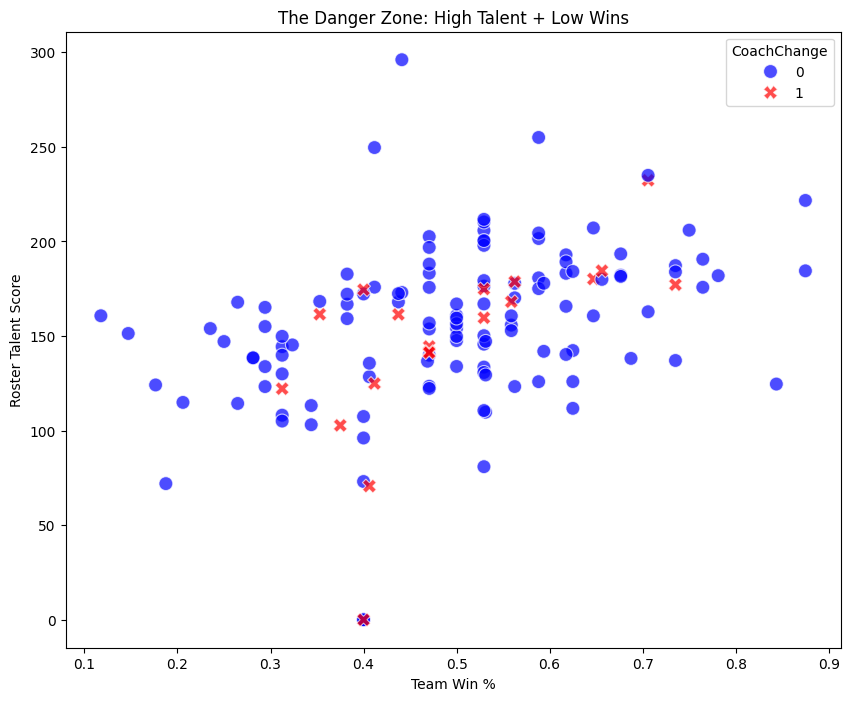

In [8]:
def getTeamPlayersStats():
  train_players_scores_list = []

  for year in range(1,TARGET_YEAR + 1):
    players_year = last_year_players_stats(year, players_teams)
    #teams_rosters_scores = players_year.groupby(["year", "tmID"])["Player_Score"].mean().reset_index()
    teams_rosters_scores = players_year.groupby(["year", "tmID"])["Player_Score"].agg(
        Player_Score_Mean='mean',
        Player_Score_Max='max',
        Player_Score_Std='std'
    ).reset_index()
    train_players_scores_list.append(teams_rosters_scores)

  train_players = pd.concat(train_players_scores_list, ignore_index=True)
  train_players = train_players.fillna(0)

  return train_players

train_players = getTeamPlayersStats()
exploratory_analysis = pd.merge(
    exploratory_analysis,
    train_players,
    on=['year', 'tmID'],
    how='left'
)

plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=exploratory_analysis,
    x='Prev_Team_Win_Pct',
    y='Player_Score_Mean',
    hue='CoachChange',
    style='CoachChange',
    palette={0: 'blue', 1: 'red'},
    s=100,
    alpha=0.7
)

plt.title("The Danger Zone: High Talent + Low Wins")
plt.xlabel("Team Win %")
plt.ylabel("Roster Talent Score")

plt.show()

Not very helpful. Looks like the other 2 variables also degrade our results so we won't add these.

Lets try to see if a trend in Win% helps.  
To calculate this, simply see the difference between the previous year and the year before that.  
- Ex: Win_Pct_Change for year 10 is Year_9_Win_Pct - Year_8_Win_Pct.

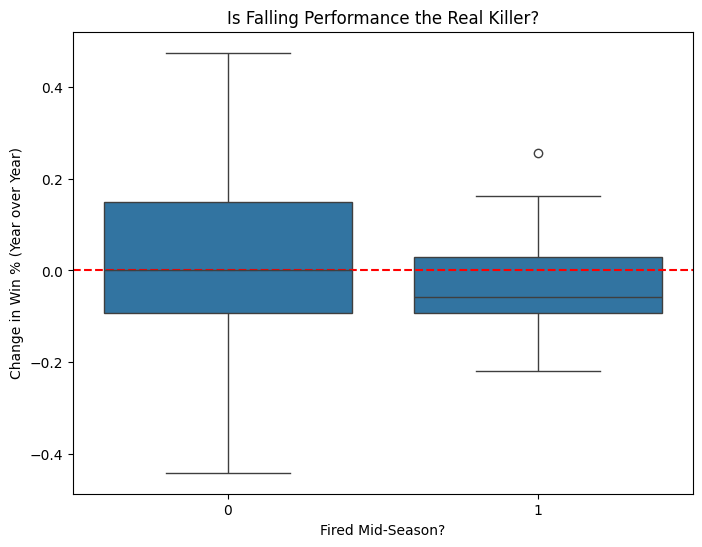

In [9]:
exploratory_analysis.sort_values(by=['tmID', 'year'], inplace=True)
exploratory_analysis['Win_Pct_Change'] = exploratory_analysis.groupby('tmID')['Prev_Team_Win_Pct'].diff()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(x='CoachChange', y='Win_Pct_Change', data=exploratory_analysis)
plt.title("Is Falling Performance the Real Killer?")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fired Mid-Season?")
plt.ylabel("Change in Win % (Year over Year)")
plt.show()

Looks like there may be an effect. Will add this stat to the training data.

Lets see if a team having a good playoff season last year ammounts to much.
To see this, we will atribute a value to each stage of the playoffs.  
- 0 -> Didn't make into the playoffs
- 1 -> Lost first round
- 2 -> Lost semis
- 3 -> Lost final
- 4 -> Champions

C:\Users\kensh\AppData\Local\Temp\ipykernel_2384\3428674146.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
C:\Users\kensh\AppData\Local\Temp\ipykernel_2384\3428674146.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Missed (0)', 'R1 Exit (1)', 'Semis Exit (2)', 'Finals Loss (3)', 'Champion (4)'])


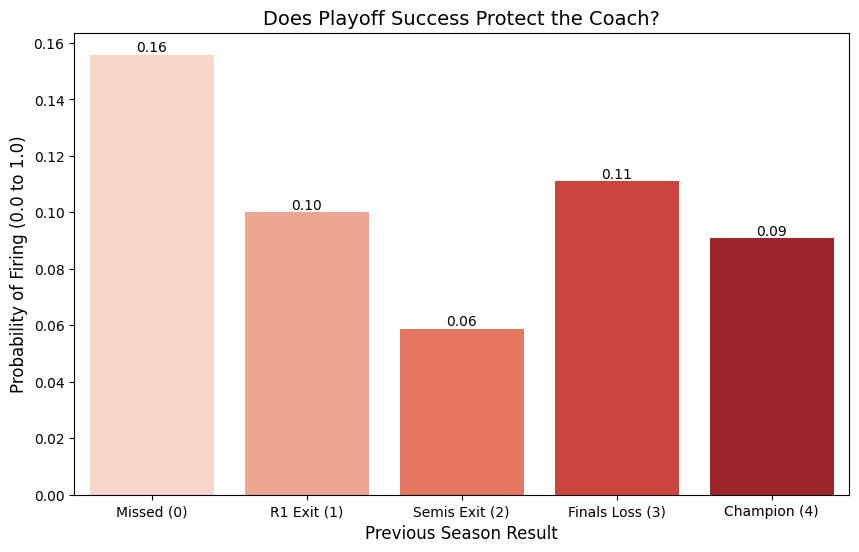

Correlation: -0.0793


In [10]:
def playoff_score():
  teams_history = teams[['year', 'tmID', 'playoff', 'firstRound', 'semis', 'finals']].copy()

  conditions = [
    teams_history['finals'] == 'W',       # 4 = Champion
    teams_history['finals'] == 'L',       # 3 = Lost Finals
    teams_history['semis'] == 'L',        # 2 = Lost Semis
    teams_history['firstRound'] == 'L',   # 1 = Lost First Round
    teams_history['playoff'] == 'Y'       # 1 = Made playoffs (fallback)
  ]
  choices = [4, 3, 2, 1, 1]
  teams_history['Playoff_Performance_Score'] = np.select(conditions, choices, default=0)
  prev_performance = teams_history[['year', 'tmID', 'Playoff_Performance_Score']].copy()
  prev_performance['year'] = prev_performance['year'] + 1

  prev_performance = prev_performance.rename(columns={
    'Playoff_Performance_Score': 'Prev_Playoff_Score'
  })

  return prev_performance

playoff_df = playoff_score()

exploratory_analysis = pd.merge(
    exploratory_analysis,
    playoff_df,
    on=['tmID', 'year'],
    how='left'
)

exploratory_analysis['Prev_Playoff_Score'] = exploratory_analysis['Prev_Playoff_Score'].fillna(0)

plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=exploratory_analysis,
    x='Prev_Playoff_Score',
    y='CoachChange',
    palette='Reds',
    errorbar=None
)

ax.set_xticklabels(['Missed (0)', 'R1 Exit (1)', 'Semis Exit (2)', 'Finals Loss (3)', 'Champion (4)'])
plt.title("Does Playoff Success Protect the Coach?", fontsize=14)
plt.ylabel("Probability of Firing (0.0 to 1.0)", fontsize=12)
plt.xlabel("Previous Season Result", fontsize=12)

for i in ax.containers:
    ax.bar_label(i, fmt='%.2f')

plt.show()

corr = exploratory_analysis['Prev_Playoff_Score'].corr(exploratory_analysis['CoachChange'])

print(f"Correlation: {corr:.4f}")


Looks like there is a bigger probability to be fired if the team leaves early or if the coach goes to the final. Lets keep this.

Coach score is value calculated from a coache's historical Win% and their whether or not they were champions at some point.  

Now we will check how coach score affects the question we are investigating.

C:\Users\kensh\AppData\Local\Temp\ipykernel_2384\2002569779.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


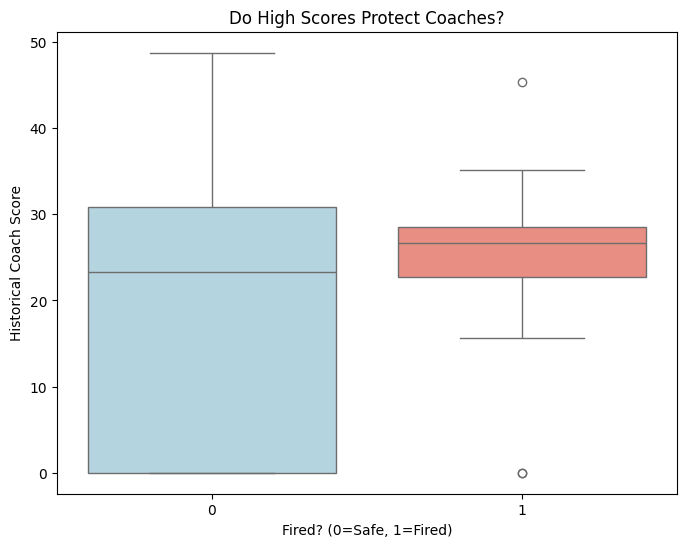

In [11]:
def compute_individual_coach_scores_for_year(target_year, all_coaches_df, all_teams_df):

    # 1. Define historic period (everything before target year)
    history_end_year = target_year - 1

    # If the year is the first, then there is no records. Value is 0
    if history_end_year < 1:
        teams_in_year = all_coaches_df[all_coaches_df['year'] == target_year]['tmID'].unique()
        return pd.DataFrame({
            'year': target_year,
            'tmID': teams_in_year,
            'Coach_Score': 0
        })

    # --- Calculate historical stats ---

    # 2. Historical Win%
    coaches_hist = all_coaches_df[all_coaches_df['year'] <= history_end_year]
    coaches_stats = coaches_hist.groupby('coachID')[['won', 'lost']].sum().reset_index()

    coaches_stats['Win Percentage'] = (
        coaches_stats['won'] / (coaches_stats['won'] + coaches_stats['lost'])
    ).fillna(0)

    # 3. Find previous champions
    winner_teams_hist = all_teams_df[
        (all_teams_df['finals'] == 'W') &
        (all_teams_df['year'] <= history_end_year)
    ][['year', 'tmID']]

    winner_coaches_hist = winner_teams_hist.merge(
        all_coaches_df[['year', 'tmID', 'coachID']],
        on=['year', 'tmID'],
        how='left'
    )
    historical_champions_set = set(winner_coaches_hist['coachID'].dropna())

    # 4. Calculate the score
    coaches_stats['Champion'] = coaches_stats['coachID'].apply(
        lambda cid: 'Yes' if cid in historical_champions_set else 'No'
    )

    coaches_stats['Coach_Score'] = (
        coaches_stats['Win Percentage'] * 50 +
        coaches_stats['Champion'].apply(lambda x: 5 if x == 'Yes' else 0)
    ).round(2)

    # --- Map Scores to teams of target year ---

    # 5. Obtain coaches from 'target_year'
    teams_and_coaches_target_year = all_coaches_df[
        all_coaches_df['year'] == target_year
    ][['tmID', 'coachID']]

    # 6. Join
    teams_with_scores = teams_and_coaches_target_year.merge(
        coaches_stats[['coachID', 'Coach_Score']],
        on='coachID',
        how='left'
    )

    # New coaches get score 0
    teams_with_scores['Coach_Score'] = teams_with_scores['Coach_Score'].fillna(0)
    teams_with_scores['year'] = target_year

    return teams_with_scores[['year', 'tmID', 'coachID', 'Coach_Score']]

def get_coach_score():
  train_coach_scores_list = []

  for year in range(1, TARGET_YEAR + 1):
      scores_for_this_year = compute_individual_coach_scores_for_year(
          target_year=year,
          all_coaches_df=coaches,
          all_teams_df=teams
      )
      train_coach_scores_list.append(scores_for_this_year)

  all_years_scores = pd.concat(train_coach_scores_list, ignore_index=True)

  return all_years_scores

all_years_scores = get_coach_score()

exploratory_analysis = pd.merge(
    exploratory_analysis,
    all_years_scores[['tmID', 'year', 'coachID', 'Coach_Score']],
    on=['tmID', 'year', 'coachID'],
    how='left'
)

exploratory_analysis['Coach_Score'] = exploratory_analysis['Coach_Score'].fillna(0)
plt.figure(figsize=(8, 6))

# Boxplot comparing Safe vs. Fired coaches
sns.boxplot(
    data=exploratory_analysis,
    x='CoachChange',
    y='Coach_Score',
    palette={'0': 'lightblue', '1': 'salmon'}
)

plt.title("Do High Scores Protect Coaches?")
plt.xlabel("Fired? (0=Safe, 1=Fired)")
plt.ylabel("Historical Coach Score")
plt.show()

Coach score looks like a good indicator. We will keep it

Now we add team playoff performane, Win Percentage Change from the 2 previous years and the number of times a team has fired a coach to the target table of our classifier.

In [12]:
teams_history = teams[['year', 'tmID', 'won', 'lost']].copy()
teams_history['total_games'] = teams_history['won'] + teams_history['lost']
teams_history['Win_Pct'] = teams_history['won'] / teams_history['total_games']

teams_history['year'] = teams_history['year'] + 1

teams_history = teams_history.rename(columns={
  'Win_Pct': 'Prev_Team_Win_Pct'
})

target_coaches = pd.merge(
    target_coaches,
    teams_history[['year', 'tmID', 'Prev_Team_Win_Pct']],
    on=['year', 'tmID'],
    how='left'
)
target_coaches['Prev_Team_Win_Pct'] = target_coaches['Prev_Team_Win_Pct'].fillna(0.4) # Preencher buracos com média

target_coaches.sort_values(by=['tmID', 'year'], inplace=True)
target_coaches['Win_Pct_Change'] = target_coaches.groupby('tmID')['Prev_Team_Win_Pct'].diff()
target_coaches['Win_Pct_Change'] = target_coaches['Win_Pct_Change'].fillna(0.0)

target_coaches = target_coaches.drop(columns=["Prev_Team_Win_Pct"])

#Get Playoff score
prev_performance = playoff_score()

target_coaches = pd.merge(
    target_coaches,
    prev_performance,
    on=['year', 'tmID'],
    how='left'
)

target_coaches['Prev_Playoff_Score'] = target_coaches['Prev_Playoff_Score'].fillna(0.0)

# Get number of firings by a team
coaches_df = coaches.copy()
coaches_df.sort_values(by=['tmID', 'year', 'stint'], inplace=True)

coaches_df['Next_Coach'] = coaches_df.groupby('tmID')['coachID'].shift(-1)

coaches_df['Change_Event'] = np.where(
    (coaches_df['coachID'] != coaches_df['Next_Coach']) & (coaches_df['Next_Coach'].notnull()),
    1,
    0
)

yearly_firings = coaches_df.groupby(['tmID', 'year'])['Change_Event'].sum().reset_index()

yearly_firings['History_Firings_Cumulative'] = yearly_firings.groupby('tmID')['Change_Event'].cumsum()

yearly_firings['Fired_Count_Before_Season'] = yearly_firings.groupby('tmID')['History_Firings_Cumulative'].shift(1).fillna(0)

target_coaches = pd.merge(
    target_coaches,
    yearly_firings[['tmID', 'year', 'Fired_Count_Before_Season']],
    on=['tmID', 'year'],
    how='left'
)

print(target_coaches)



    tmID  year     coachID  CoachChange  Win_Pct_Change  Prev_Playoff_Score  \
0    ATL     9  meadoma99w            0        0.000000                 0.0   
1    ATL    10  meadoma99w            0       -0.282353                 0.0   
2    ATL    11  meadoma99w            0        0.411765                 1.0   
3    CHA     1  dunntr01wc            0        0.000000                 0.0   
4    CHA     2  donovan99w            0       -0.150000                 0.0   
..   ...   ...         ...          ...             ...                 ...   
149  WAS     7  adubari99w            0       -0.029412                 0.0   
150  WAS     8  adubari99w            1        0.058824                 1.0   
151  WAS     9  rollitr01w            1       -0.058824                 0.0   
152  WAS    10  plankju99w            0       -0.176471                 0.0   
153  WAS    11  laceytr99w            0        0.176471                 1.0   

     Fired_Count_Before_Season  
0                 

Check if the current coach is new. Adding this improves our results.


In [13]:
target_coaches = target_coaches.sort_values(['tmID', 'year'])

target_coaches['Is_New_Coach'] = target_coaches.groupby('tmID')['CoachChange'].shift(1)

target_coaches['Is_New_Coach'] = target_coaches['Is_New_Coach'].fillna(1)

print(target_coaches[['tmID', 'year', 'CoachChange', 'Is_New_Coach']])


    tmID  year  CoachChange  Is_New_Coach
0    ATL     9            0           1.0
1    ATL    10            0           0.0
2    ATL    11            0           0.0
3    CHA     1            0           1.0
4    CHA     2            0           0.0
..   ...   ...          ...           ...
149  WAS     7            0           0.0
150  WAS     8            1           0.0
151  WAS     9            1           1.0
152  WAS    10            0           1.0
153  WAS    11            0           0.0

[154 rows x 4 columns]


Coach tenure. Adding this variable appears to improve the final results.

In [14]:
target_coaches.sort_values(by=['tmID', 'year'], inplace=True)

target_coaches['Coach_Tenure'] = target_coaches.groupby(['tmID', 'coachID']).cumcount() + 1

print(target_coaches[['tmID', 'year', 'coachID', 'Is_New_Coach', 'Coach_Tenure']].head())

  tmID  year     coachID  Is_New_Coach  Coach_Tenure
0  ATL     9  meadoma99w           1.0             1
1  ATL    10  meadoma99w           0.0             2
2  ATL    11  meadoma99w           0.0             3
3  CHA     1  dunntr01wc           1.0             1
4  CHA     2  donovan99w           0.0             1


Add coach score

In [15]:
train_coaches = get_coach_score()

target_coaches = pd.merge(
    target_coaches,
    train_coaches,
    on=['tmID', 'year', 'coachID'],
    how='left'
)
target_coaches['Coach_Score'] = target_coaches['Coach_Score'].fillna(0)
print(target_coaches)



    tmID  year     coachID  CoachChange  Win_Pct_Change  Prev_Playoff_Score  \
0    ATL     9  meadoma99w            0        0.000000                 0.0   
1    ATL    10  meadoma99w            0       -0.282353                 0.0   
2    ATL    11  meadoma99w            0        0.411765                 1.0   
3    CHA     1  dunntr01wc            0        0.000000                 0.0   
4    CHA     2  donovan99w            0       -0.150000                 0.0   
..   ...   ...         ...          ...             ...                 ...   
149  WAS     7  adubari99w            0       -0.029412                 0.0   
150  WAS     8  adubari99w            1        0.058824                 1.0   
151  WAS     9  rollitr01w            1       -0.058824                 0.0   
152  WAS    10  plankju99w            0       -0.176471                 0.0   
153  WAS    11  laceytr99w            0        0.176471                 1.0   

     Fired_Count_Before_Season  Is_New_Coach  Coach

Prepare data to the classifier.

In [16]:
target_coaches.loc[target_coaches['year'] == TARGET_YEAR, 'CoachChange'] = np.nan
target_coaches['Coach_Score'] = target_coaches['Coach_Score'].fillna(0)
target_coaches['Fired_Count_Before_Season'] = target_coaches['Fired_Count_Before_Season'].fillna(0)

print(target_coaches)

    tmID  year     coachID  CoachChange  Win_Pct_Change  Prev_Playoff_Score  \
0    ATL     9  meadoma99w          0.0        0.000000                 0.0   
1    ATL    10  meadoma99w          0.0       -0.282353                 0.0   
2    ATL    11  meadoma99w          NaN        0.411765                 1.0   
3    CHA     1  dunntr01wc          0.0        0.000000                 0.0   
4    CHA     2  donovan99w          0.0       -0.150000                 0.0   
..   ...   ...         ...          ...             ...                 ...   
149  WAS     7  adubari99w          0.0       -0.029412                 0.0   
150  WAS     8  adubari99w          1.0        0.058824                 1.0   
151  WAS     9  rollitr01w          1.0       -0.058824                 0.0   
152  WAS    10  plankju99w          0.0       -0.176471                 0.0   
153  WAS    11  laceytr99w          NaN        0.176471                 1.0   

     Fired_Count_Before_Season  Is_New_Coach  Coach

Replace CoachChnage values for the target year and apply run the selected model(XGB Model).

In [17]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline

TARGET_YEAR = 10
target_coaches_year_10 = target_coaches.copy()
target_coaches_year_10.loc[target_coaches['year'] == TARGET_YEAR, 'CoachChange'] = np.nan

feature_cols = [
    'Win_Pct_Change',
    'Prev_Playoff_Score',
    'Coach_Score',
    'Is_New_Coach',
    'Coach_Tenure',
    'Fired_Count_Before_Season'
]

df_train = target_coaches_year_10[target_coaches['year'] < TARGET_YEAR].dropna(subset=['CoachChange']).copy()

df_predict = target_coaches_year_10[target_coaches['year'] == TARGET_YEAR].copy()

X_train = df_train[feature_cols]
y_train = df_train['CoachChange'].astype(int)

X_predict = df_predict[feature_cols]

model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.02,
    scale_pos_weight=5,
    max_depth=4,
    subsample=0.8
)
# model_random_forest = RandomForestClassifier(n_estimators=400, random_state=42, max_depth=5, class_weight="balanced", min_samples_leaf=10)
# model_lr = make_pipeline(
#     StandardScaler(),
#     LogisticRegression(class_weight='balanced', random_state=42, C=0.1)
# )

# model = VotingClassifier(
#     estimators=[('rf', model_random_forest), ('xgb', model_xgb), ('lr', model_lr)],
#     voting='soft'
# )

model.fit(X_train, y_train)

predictions = model.predict(X_predict)
probs = model.predict_proba(X_predict)[:, 1]

print(predictions)

df_predict['Predicted_Change'] = predictions
df_predict['Firing_Probability'] = probs

# Filter to show only the teams predicted to change
firing_candidates = df_predict[df_predict['Predicted_Change'] == 1]

print(f"Teams predicted to change coaches in Year {TARGET_YEAR}:")
print(firing_candidates[['tmID', 'coachID', 'Firing_Probability', 'Win_Pct_Change', 'Fired_Count_Before_Season', 'Coach_Score', 'Coach_Tenure']])

firing_candidates = df_predict.sort_values(['Firing_Probability'], ascending=False).copy()
print(f"Probabilities to change coaches in Year {TARGET_YEAR}:")
print(firing_candidates[['tmID', 'coachID', 'Firing_Probability', 'Win_Pct_Change', 'Fired_Count_Before_Season', 'Coach_Score', 'Coach_Tenure']])



[0 0 0 0 0 0 0 0 0 0 0 0 0]
Teams predicted to change coaches in Year 10:
Empty DataFrame
Columns: [tmID, coachID, Firing_Probability, Win_Pct_Change, Fired_Count_Before_Season, Coach_Score, Coach_Tenure]
Index: []
Probabilities to change coaches in Year 10:
    tmID     coachID  Firing_Probability  Win_Pct_Change  \
119  SAC  bouceje01w            0.480370       -0.029412   
13   CHI   keyst99wc            0.434196       -0.058824   
55   IND  dunnli99wc            0.349697       -0.117647   
36   DET  laimbbi01w            0.176686       -0.058824   
25   CON  thibami99w            0.075780        0.088235   
105  PHO  gaineco01w            0.056914       -0.205882   
152  WAS  plankju99w            0.034273       -0.176471   
66   LAS  coopemi01w            0.029110        0.294118   
1    ATL  meadoma99w            0.020603       -0.282353   
80   MIN  gilloje01w            0.008894        0.176471   
126  SAS  hugheda99w            0.007375        0.117647   
91   NYL  coylepa99w 

Now calculate for year 11

In [18]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline

TARGET_YEAR = 11

feature_cols = [
    'Win_Pct_Change',
    'Prev_Playoff_Score',
    'Coach_Score',
    'Is_New_Coach',
    'Coach_Tenure',
    'Fired_Count_Before_Season'
]

df_train = target_coaches[target_coaches['year'] < TARGET_YEAR].dropna(subset=['CoachChange']).copy()

df_predict = target_coaches[target_coaches['year'] == TARGET_YEAR].copy()

X_train = df_train[feature_cols]
y_train = df_train['CoachChange'].astype(int)

X_predict = df_predict[feature_cols]

model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.02,
    scale_pos_weight=5,
    max_depth=4,
    subsample=0.8
)
# model_random_forest = RandomForestClassifier(n_estimators=400, random_state=42, max_depth=5, class_weight="balanced", min_samples_leaf=10)
# model_lr = make_pipeline(
#     StandardScaler(),
#     LogisticRegression(class_weight='balanced', random_state=42, C=0.1)
# )

# model = VotingClassifier(
#     estimators=[('rf', model_random_forest), ('xgb', model_xgb), ('lr', model_lr)],
#     voting='soft'
# )

model.fit(X_train, y_train)

predictions = model.predict(X_predict)
probs = model.predict_proba(X_predict)[:, 1]

print(predictions)

df_predict['Predicted_Change'] = predictions
df_predict['Firing_Probability'] = probs

# Filter to show only the teams predicted to change
firing_candidates = df_predict[df_predict['Predicted_Change'] == 1]

print(f"Teams predicted to change coaches in Year {TARGET_YEAR}:")
print(firing_candidates[['tmID', 'coachID', 'Firing_Probability', 'Win_Pct_Change', 'Fired_Count_Before_Season', 'Coach_Score', 'Coach_Tenure']])

firing_candidates = df_predict.sort_values(['Firing_Probability'], ascending=False).copy()
print(f"Probabilities to change coaches in Year {TARGET_YEAR}:")
print(firing_candidates[['tmID', 'coachID', 'Firing_Probability', 'Win_Pct_Change', 'Fired_Count_Before_Season', 'Coach_Score', 'Coach_Tenure']])



[0 0 0 0 0 0 0 0 0 1 0 0]
Teams predicted to change coaches in Year 11:
    tmID     coachID  Firing_Probability  Win_Pct_Change  \
138  SEA  aglerbr99w            0.907138       -0.058824   

     Fired_Count_Before_Season  Coach_Score  Coach_Tenure  
138                        2.0        24.83             3  
Probabilities to change coaches in Year 11:
    tmID     coachID  Firing_Probability  Win_Pct_Change  \
138  SEA  aglerbr99w            0.907138       -0.058824   
26   CON  thibami99w            0.308181       -0.147059   
139  TUL  richano99w            0.213779        0.000000   
127  SAS  hugheda99w            0.077670       -0.264706   
67   LAS  gilloje01w            0.025638       -0.058824   
2    ATL  meadoma99w            0.022858        0.411765   
106  PHO  gaineco01w            0.017543        0.205882   
92   NYL  whisejo99w            0.011386       -0.176471   
56   IND  dunnli99wc            0.007657        0.147059   
153  WAS  laceytr99w            0.004069   